In [50]:
import itertools
import random

import torch
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_scatter import scatter_mean
from collections import defaultdict

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *
from networkx.algorithms.centrality import degree_centrality
import pickle
from itertools import zip_longest
from torch_geometric.utils import degree

from custom.utils import *

In [51]:
import networkx as nx
import torch
from torch_geometric.utils import degree
import time


class MCS:
    def __init__(self, mp):
        self.mp = mp
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.visited = set()
        self.time_limit = 5
        self.start_time = None

    def find_mcs(self, G1, G2):
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.visited = set()
        self.start_time = time.time()

        G1_degrees = degree(G1.edge_index[0], G1.num_nodes)
        G2_degrees = degree(G2.edge_index[0], G2.num_nodes)

        nodes1 = list(range(G1.num_nodes))
        nodes2 = list(range(G2.num_nodes))

        for n1 in nodes1:
            for n2 in nodes2:
                if (n1, n2) in self.mp:
                    M = {n1: n2}
                    neighbors1 = set(G1.edge_index[1][G1.edge_index[0] == n1].tolist())
                    neighbors2 = set(G2.edge_index[1][G2.edge_index[0] == n2].tolist())
                    self.match(
                        G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2
                    )
        return self.all_mappings

    def match(self, G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2):
        if time.time() - self.start_time > self.time_limit:
            return

        state = (frozenset(M.items()), frozenset(neighbors1), frozenset(neighbors2))
        if state in self.visited:
            return
        self.visited.add(state)

        edge_count = self.count_edges(M, G1, G2)

        if len(M) > self.max_size or (
            len(M) == self.max_size and edge_count > self.edge_count
        ):
            self.max_size = len(M)
            self.edge_count = edge_count
            self.all_mappings = [M.copy()]
            self.unique_mappings = {self.canonical_form(M)}
        elif len(M) == self.max_size and edge_count == self.edge_count:
            canonical = self.canonical_form(M)
            if canonical not in self.unique_mappings:
                self.all_mappings.append(M.copy())
                self.unique_mappings.add(canonical)

        candidates1 = sorted(neighbors1, key=lambda n: -G1_degrees[n].item())
        candidates2 = sorted(neighbors2, key=lambda n: -G2_degrees[n].item())

        for n1 in candidates1:
            if n1 not in M:
                for n2 in candidates2:
                    if n2 not in M.values() and self.feasible(n1, n2, M, G1, G2):
                        M[n1] = n2
                        new_neighbors1 = set(
                            G1.edge_index[1][G1.edge_index[0] == n1].tolist()
                        )
                        new_neighbors2 = set(
                            G2.edge_index[1][G2.edge_index[0] == n2].tolist()
                        )
                        neighbors1.update(new_neighbors1 - set(M.keys()))
                        neighbors2.update(new_neighbors2 - set(M.values()))
                        self.match(
                            G1,
                            G2,
                            M,
                            G1_degrees,
                            G2_degrees,
                            neighbors1,
                            neighbors2,
                        )
                        del M[n1]
                        neighbors1.difference_update(new_neighbors1)
                        neighbors2.difference_update(new_neighbors2)

    def feasible(self, n1, n2, M, G1, G2):
        if not torch.equal(G1.x[n1], G2.x[n2]):
            return False
        if (n1, n2) not in self.mp:
            return False

        count1 = 0
        count2 = 0

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if neighbor.item() in M:
                count1 += 1

        for neighbor in G2.edge_index[1][G2.edge_index[0] == n2]:
            if neighbor.item() in M.values():
                count2 += 1

        if count1 != count2:
            return False

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if (
                neighbor.item() in M
                and not (
                    G2.edge_index[1][G2.edge_index[0] == n2] == M[neighbor.item()]
                ).any()
            ):
                return False

        return True

    def count_edges(self, M, G1, G2):
        edge_count = 0
        for u1, v1 in M.items():
            for u2, v2 in M.items():
                if u1 != u2:
                    u1_v1_exists = (
                        (G1.edge_index[0] == u1) & (G1.edge_index[1] == u2)
                    ).any() or (
                        (G1.edge_index[0] == u2) & (G1.edge_index[1] == u1)
                    ).any()
                    u2_v2_exists = (
                        (G2.edge_index[0] == v1) & (G2.edge_index[1] == v2)
                    ).any() or (
                        (G2.edge_index[0] == v2) & (G2.edge_index[1] == v1)
                    ).any()
                    if u1_v1_exists and u2_v2_exists:
                        edge_count += 1
        return edge_count

    def canonical_form(self, M):
        G1_set = set(M.keys())
        G2_set = set(M.values())
        return (frozenset(G1_set), frozenset(G2_set))

In [52]:
cycle = torch.load("cycle.pt")
complete = torch.load("complete.pt")
line = torch.load("line.pt")
star = torch.load("star.pt")
noisy_cycle = torch.load("noisy_cycle.pt")
noisy_complete = torch.load("noisy_complete.pt")
noisy_line = torch.load("noisy_line.pt")
noisy_star = torch.load("noisy_star.pt")

In [53]:
# import matplotlib.pyplot as plt
# import networkx as nx
# from torch_geometric.utils import to_networkx
# from torch_geometric.data import Data
# import torch


# # Function to generate a random graph
# def generate_random_graph(num_nodes, num_edges):
#     edge_index = torch.randint(0, num_nodes, (2, num_edges), dtype=torch.long)
#     data = Data(edge_index=edge_index, num_nodes=num_nodes)
#     return data


# graphs = [
#     cycle,
#     complete,
#     line,
#     star,
#     noisy_cycle,
#     noisy_complete,
#     noisy_line,
#     noisy_star,
# ]

# fig = plt.figure(figsize=(20, 10))


# names = ["Cyclic", "Complete", "Line", "Star"]

# gs_left = fig.add_gridspec(2, 2, left=0.05, right=0.40, wspace=0.3, hspace=0.3)
# gs_right = fig.add_gridspec(2, 2, left=0.60, right=0.95, wspace=0.3, hspace=0.3)

# for i in range(2):
#     for j in range(2):
#         ax = fig.add_subplot(gs_left[i, j])
#         G = to_networkx(graphs[i * 2 + j], to_undirected=True)
#         nx.draw(
#             G,
#             ax=ax,
#             node_color="#3b8bc2",
#             node_size=200,
#             edge_color="k",
#             linewidths=2,
#             font_size=15,
#         )
#         ax.set_title(f"{names[i * 2 + j]} Graph")

# for i in range(2):
#     for j in range(2):
#         ax = fig.add_subplot(gs_right[i, j])
#         G = to_networkx(graphs[4 + i * 2 + j], to_undirected=True)
#         nx.draw(
#             G,
#             ax=ax,
#             node_color="#3b8bc2",
#             node_size=200,
#             edge_color="k",
#             linewidths=2,
#             font_size=15,
#         )
#         ax.set_title(f"Noisy {names[i * 2 + j]} Graph")

# fig.suptitle("Geometric Shapes", fontsize=16)

/var/folders/st/cyh3v8ln22sdswp1s386w5vw0000gn/T/ipykernel_87748/612763316.py:44: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.5, hspace=0.2)


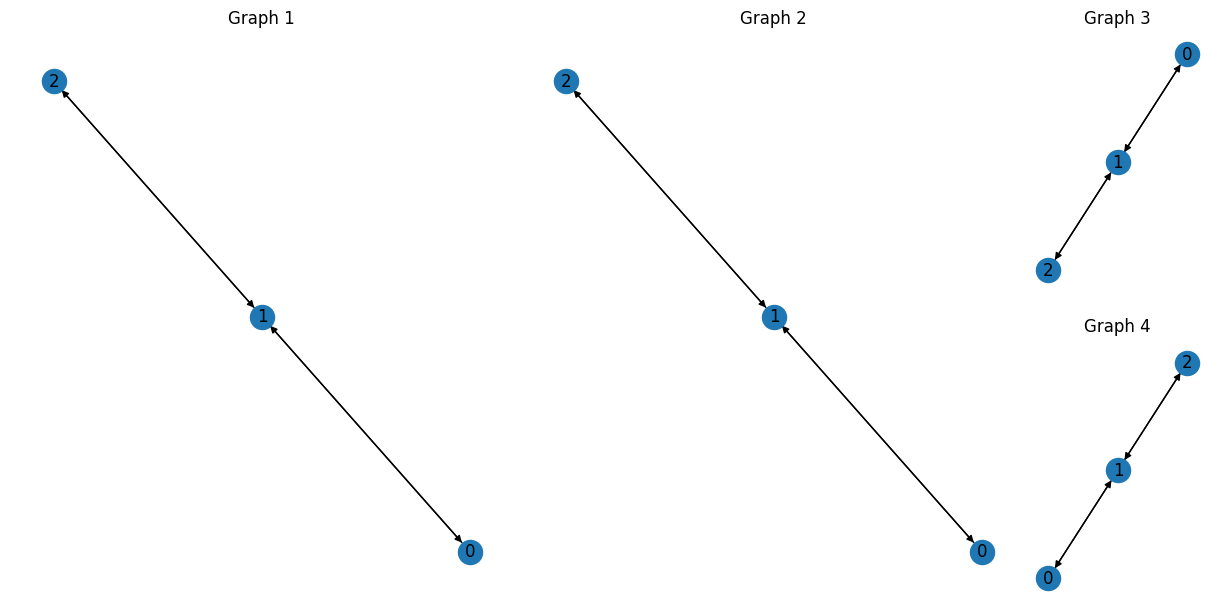

In [55]:
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

# Create some sample data for demonstration
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data1 = Data(x=x, edge_index=edge_index)
data2 = Data(x=x, edge_index=edge_index)
data3 = Data(x=x, edge_index=edge_index)
data4 = Data(x=x, edge_index=edge_index)

# Convert to NetworkX graphs
G1 = to_networkx(data1)
G2 = to_networkx(data2)
G3 = to_networkx(data3)
G4 = to_networkx(data4)

# Create a figure with specified layout
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(2, 3, width_ratios=[3, 3, 1], height_ratios=[2, 2])

# Plot each graph
ax1 = fig.add_subplot(gs[:, 0])
ax1.set_title("Graph 1")
nx.draw(G1, ax=ax1, with_labels=True)

ax2 = fig.add_subplot(gs[:, 1])
ax2.set_title("Graph 2")
nx.draw(G2, ax=ax2, with_labels=True)

ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Graph 3")
nx.draw(G3, ax=ax3, with_labels=True)

ax4 = fig.add_subplot(gs[1, 2])
ax4.set_title("Graph 4")
nx.draw(G4, ax=ax4, with_labels=True)

# Adjust layout
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.show()